In [ ]:
# exif2track - script to plot photo locations and tabulate image info

import __future__
import sys
# argument parsing
import argparse
# glob for files
import glob
# file path tools
import os
# os.path import join, basename, splitdrive, split
# regular expression
import re
# math library
import math
# Numpy
import numpy as np

# GDAL Python library
from osgeo import osr
# EXIF Reader
import exifread
# Image library
from PIL import Image

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

src_crs = 'EPSG:4326'
dst_crs = 'EPSG:26919'

# source coordinate system
srs_cs = osr.SpatialReference()
srs_cs.SetFromUserInput(src_crs)

# destination coordinate system
dst_cs = osr.SpatialReference()
dst_cs.SetFromUserInput(dst_crs)

# osr image transformation object
transform = osr.CoordinateTransformation(srs_cs, dst_cs)

# print coordinate system information
print " >> SOURCE COORDINATE REFERENCE SYSTEM: "
print srs_cs

print " >> DESTINATION COORDINATE REFERENCE SYSTEM: "
print dst_cs

def averageRGB(fpath):
    """
    Return the average RBG color of an image
    """
    im = Image.open(fpath)
    h=np.array( im.histogram() )
    h=np.reshape(h,(3,256))

    rgb = np.zeros((1,3))
    wts = np.arange(0,254)
    for i in range(0,3):
        rgb[0,i] = sum(h[i,0:254]*wts)/sum(h[i,0:254])

    return rgb


def getGPSFiles(filepath):
    """
    Return a list of files with GPS data
    """
    files_gps = []
    files = sorted(glob.glob(filepath))
    n_images = len(files)
    print("Found {0} files.\n".format(n_images))

    n_images_GPS = 0
    for file in files:
        fs = open(file,'rb')

        # intialize arrays
        lat = []
        lon = []
        latref = []
        lonref = []
        alt = []
        time = []

        # attempt to read files
        try:
            tags = exifread.process_file(fs)
        except:
            print "No EXIF Data"
        try:
            try:
                lon = tags['GPS GPSLongitude']
                lat = tags['GPS GPSLatitude']
            except:
                print 'failed latlon'
            try:
                latref = tags['GPS GPSLatitudeRef']
                lonref = tags['GPS GPSLongitudeRef']
            except:
                print 'failed latref or lonref'
            
                
            files_gps.append(file)
            n_images_GPS += 1
        except KeyError:
            print "No GPS data for this image: ",file

        try:
            alt = tags['GPS GPSAltitude']
        except:
            print "No altitude data for this image: ",file
            
        # Get time information primarily from GPSTimeStamp
        try:
            time = tags['GPS GPSTimeStamp']
        except KeyError:
            time = tags['EXIF DateTimeOriginal']
            print "No GPS Time Stamp for this image: ", file
            
    # raise warning if no images have GPS data
    if n_images_GPS == 0:
        raise UserWarning('No images with GPS')
    else:
        print "Images with GPS: %d out of %d - %.2f%%" % (n_images_GPS, n_images, 100*n_images_GPS/n_images)
    
    return files_gps


def transformCoordinateSystem(files):
    """
    Transform Coordinate System
    Read EXIF and GPS information from a list of pathnames
    and return an np.array with UTM Zone 19 North coordinates.
    
    Includes code from Eddie Obrupta, (c) Raptor Maps, Inc.
    csherwood@usgs.gov
    """
    nfiles = len(files)
    print 'nfiles=',nfiles
    # initialize arrays
    fp_names = []
    fp = np.ones((15,nfiles),dtype=float)
    fp = np.nan*fp
    
    # loop over files, check for GPS data
    k = 0
    for file in files:
        fs = open(file,'rb')
        tags = exifread.process_file(fs)
        lon = tags['GPS GPSLongitude']
        lat = tags['GPS GPSLatitude']
        latref = tags['GPS GPSLatitudeRef']
        lonref = tags['GPS GPSLongitudeRef']
        try:
            alt = tags['GPS GPSAltitude']
            # alt_num = np.float(eval(str(alt))) # this does integer math on strings like 1284/2
            alt_num = eval(compile(str(alt),'<string>','eval', __future__.division.compiler_flag))
            # print alt, alt_num
        except:
            alt_num = -999.9

        try:
            time = tags['GPS GPSTimeStamp']
            date = tags['GPS GPSDate']
            timenum = np.nan
            datenum = np.nan
            # convert time tag
            try:
                times=(str(time))
                exec 'timesa = np.array('+times+')'
                timenum = timesa.astype(np.float)
            except:
                print('Could not convert time tag in ',file)
 
            dates = str(date).split(':')
            datesa = np.array(dates,dtype='|S4')
            datenum = datesa.astype(np.float)
            dta = np.concatenate((datenum,timenum),axis=0)

        except:
            time = tags['EXIF DateTimeOriginal']
            time_split = str(time).split()
            datenum = time_split[0].split(':')
            time  = time_split[1].split(':')
            timenum = [float(i) for i in time]
            dta = np.concatenate((datenum,timenum),axis=0)
            print('Using EXIF time stamp in ',file)
            
        # get average color
        rbg = np.zeros((1,3))
        try:
            rgb = averageRGB(file)
        except:
            print('No color from ',file)


        # convert time to seconds (Note: this does not work across midnight, and it is UTC, so it will cause problems eventually)
        time_dec = (timenum[0]+timenum[1]/60.0 + timenum[2]/3600.0)*3600 # seconds
        
        ## Latitude
        # use regular expression to get value between brackets
        y_regx = re.search('\[(.*?)\]', str(lat))
        y_regx = y_regx.group(1)
        y_regx = y_regx.split(', ')
        # properly convert values to floats
        y = []
        y.append(eval(compile(y_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[2],'<string>','eval', __future__.division.compiler_flag)))

        ## Longitude
        x_regx = re.search('\[(.*?)\]', str(lon))
        x_regx = x_regx.group(1)
        x_regx = x_regx.split(', ')
        x = []
        x.append(eval(compile(x_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[2],'<string>','eval', __future__.division.compiler_flag)))
        
        # convert from latitude longitude minutes seconds to decimal
        ddx = (np.sign(x[0]))*(math.fabs(x[0]) + (x[1]/60.0) + (x[2]/3600.0))
        ddy = (np.sign(y[0]))*(math.fabs(y[0]) + (y[1]/60.0) + (y[2]/3600.0))

        # handle longitude west values to negative
        if str(lonref) == 'W':
            ddx = -1.0*ddx
        # handle latitude south values to negative
        if str(latref) == 'S':
            ddy = -1.0*ddy
            
        # get the coordinates in lat long
        # TransformPoint(X,Y) i.e. -> (long, lat)
        u = transform.TransformPoint(ddx, ddy)

        # append file names to array
        drive, path_and_file = os.path.splitdrive(file)
        path, fn = os.path.split(path_and_file)
        fp_names.append(fn)

        r = rgb[0,0]/255.
        g = rgb[0,1]/255.
        b = rgb[0,2]/255.
        
        # fill data array
        fp[:,k]=[dta[0],dta[1],dta[2],dta[3],dta[4],dta[5],ddx,ddy,u[0],u[1],alt_num,time_dec,r,g,b]

        # close connection to file
        fs.close()
        k = k+1
    
    return fp_names,fp

# input arguments
# image folder

imdir='flight_1_rgb_1'
#imdir='flight_1_rgb_2'
#imdir='flight_2_rgb_1'
#imdir='flight_2_nir_1'
#imdir='testdir'

# path to image folder
#tdir = '/home/csherwood/crs/proj/2016_CACO/2016-3-1_raptormaps_cape_cod/'
tdir = 'd:/crs/proj/2016_CACO/2016-03-01_CACO_images/'
filetype = 'JPG'

# construct filepath
filepath = tdir+imdir+'/*.JPG'

print "Reading image files from ",filepath
files = getGPSFiles(filepath)
print "Transforming coordinate system"
fpnames,fp = transformCoordinateSystem(files)

# write formatted list of images
csvpath = tdir+imdir+'.csv'
fid = open(csvpath,'w')
for i in np.arange(fp.shape[1]):
    fid.write("{0:s},{1:4.0f},{2:02.0f},{3:02.0f},{4:02.0f},{5:02.0f},{6:06.3f},{7:11.6f},{8:10.6f},{9: 11.3f},{10: 11.3f},{11:6.1f}\n"       .format(fpnames[i],fp[0,i],fp[1,i],fp[2,i],fp[3,i],fp[4,i],fp[5,i],fp[6,i],fp[7,i],fp[8,i],fp[9,i],fp[10,i]))
fid.close()

# calculate ground speed
eps = np.finfo(float).eps
dx=np.diff(fp)
dist = np.sqrt( np.sum(dx[8:10,:]**2,axis = 0) )
dt = dx[11,::]
#print dx[:,]
print 'Mean delta xyz (m):',np.mean(dist)
print 'Mean delta t (s):',np.mean(dt)
speed = dist/(dt+eps)
print('Ground speed: Mean {0}, Max: {1}, Min: {2} m/s\n'.format(np.mean(speed), np.max(speed), np.min(speed)))

<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000000005876CF8>
<function shape at 0x0000

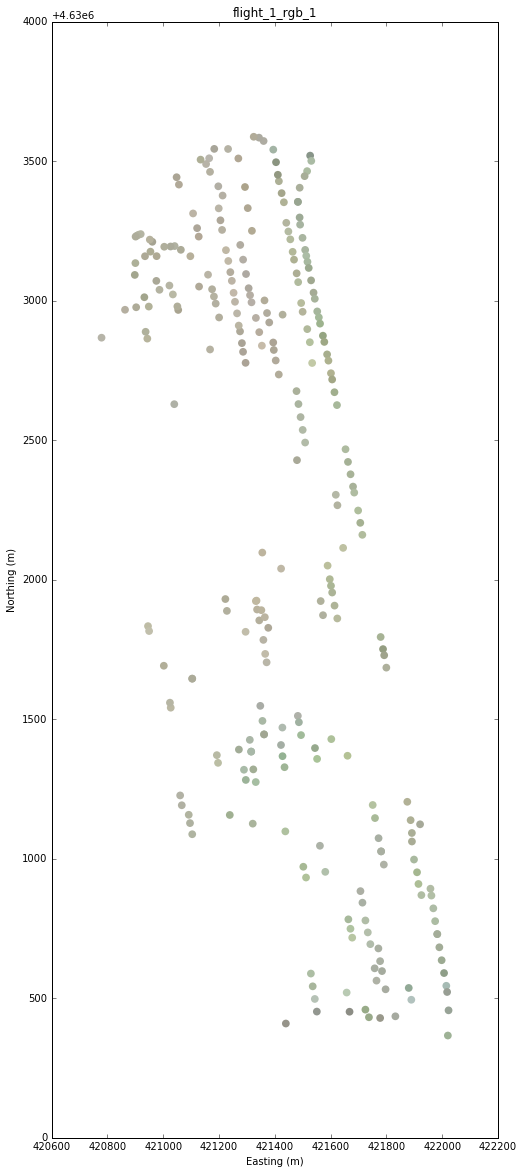

In [16]:
# plot UTM x,y with average image color
rgb = fp[12:15,:]
ss = np.ones_like(fp[1,:])*20.

fig,ax = plt.subplots(figsize=(8,20))
for i in range(len(fp[0,:])):
    col = rgb[:,i]
    print(np.shape(col))
    try:
        ax.scatter(fp[8,i],fp[9,i],s=60,c=rgb[:,i],edgecolors='none')
    except:
        print(col)
    
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title(imdir)
plt.xlim(420600,422200)
plt.ylim(4630000,4634000)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.savefig(tdir+imdir+'track.png')

In [17]:
print rgb[:,0:30]

[[ 0.53333333  0.66666667  0.6745098   0.65882353  0.66666667  0.65098039
   0.59607843  0.61568627  0.65490196  0.6627451   0.65882353  0.6745098
   0.65490196  0.60784314  0.62745098  0.64705882  0.65490196  0.64705882
   0.64313725  0.61568627  0.58431373  0.61960784  0.65490196  0.68235294
   0.69411765  0.63921569  0.63137255  0.65490196  0.69411765  0.66666667]
 [ 0.58431373  0.73333333  0.7372549   0.68235294  0.68627451  0.68627451
   0.64705882  0.66666667  0.70588235  0.70980392  0.70980392  0.74117647
   0.7254902   0.6627451   0.65882353  0.67058824  0.70196078  0.71372549
   0.7254902   0.70196078  0.64705882  0.65882353  0.68235294  0.69803922
   0.69803922  0.65490196  0.68627451  0.72156863 -0.70196078 -0.70980392]
 [ 0.5372549   0.64313725  0.63137255  0.59607843  0.60784314  0.61176471
   0.56862745  0.58823529  0.63137255  0.62745098  0.62745098  0.65098039
   0.62745098  0.56078431  0.56470588  0.58431373  0.60784314  0.61176471
   0.60392157  0.55686275  0.50980392

In [10]:
len(fp[0,:])

1251

In [14]:
print(rgb[:,1])

[ 0.66666667  0.73333333  0.64313725]


In [15]:
print i

28
